In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity
from typing import List, Tuple

In [28]:
tsv_file = "Data/metrics_collector.tsv"

data = pd.read_csv(tsv_file, sep='\t', header=None)

column_names = [
    'account_id', 'name', 'point', 'call_count', 'total_call_time', 
    'total_exclusive_time', 'min_call_time', 'max_call_time', 
    'sum_of_squares', 'instances', 'language', 'app_name', 
    'app_id', 'scope', 'host', 'display_host', 'pid', 
    'agent_version', 'labels'
]

data.columns = column_names

data["point"] = pd.to_datetime(data["point"])


data = data.sort_values(by = "point")

data.head(100)

/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_96214/1838360545.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(tsv_file, sep='\t', header=None)


,account_id,name,point,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances,language,app_name,app_id,scope,host,display_host,pid,agent_version,labels
0,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:32:00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
1631994,1,Datastore/instance/Redis/redis/6379,2024-04-15 23:32:00,1004.5,0.007253,0.007253,5.340000e-07,0.004418,1.106032e-05,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
7791744,1,MemoryPool/Heap/G1 Old Gen/Max,2024-04-15 23:32:00,12.0,11736.000000,11736.000000,9.780000e+02,978.000000,1.147781e+07,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
16520436,1,Threads/Time/CPU/qtp#-#/SystemTime,2024-04-15 23:32:00,21.5,1.366000,1.366000,3.500000e-02,0.099000,9.165700e-02,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
16512917,1,Threads/TotalTime/New Relic Harvest Service/Cp...,2024-04-15 23:32:00,1.0,0.005500,0.005500,5.000000e-03,0.006000,3.050000e-05,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12800627,1,Threads/Count/Common-Cleaner/BlockedCount,2024-04-15 23:32:00,1.0,6.500000,6.500000,6.000000e+00,7.000000,4.250000e+01,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
15832320,1,Threads/Time/CPU/Thread-# (#)/SystemTime,2024-04-15 23:32:00,11.0,0.001000,0.001000,0.000000e+00,0.001000,1.000000e-06,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
15842294,1,Threads/Time/CPU/New Relic Faster Harvest Serv...,2024-04-15 23:32:00,1.0,0.003500,0.003500,0.000000e+00,0.007000,2.450000e-05,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
2528360,1,DurationByCaller/Unknown/Unknown/Unknown/HTTP/all,2024-04-15 23:32:00,3852.0,29.848598,29.848598,9.144600e-05,0.785708,2.046837e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}


In [22]:
for column in data.columns:
    print(f"Количество уникальных значений в колонке {column} = {len(data[column].unique())}")

Количество уникальных значений в колонке account_id = 1
Количество уникальных значений в колонке name = 723
Количество уникальных значений в колонке point = 43272
Количество уникальных значений в колонке call_count = 20779
Количество уникальных значений в колонке total_call_time = 3062890
Количество уникальных значений в колонке total_exclusive_time = 3085886
Количество уникальных значений в колонке min_call_time = 1209789
Количество уникальных значений в колонке max_call_time = 1650155
Количество уникальных значений в колонке sum_of_squares = 3736870
Количество уникальных значений в колонке instances = 7
Количество уникальных значений в колонке language = 1
Количество уникальных значений в колонке app_name = 1
Количество уникальных значений в колонке app_id = 1
Количество уникальных значений в колонке scope = 29
Количество уникальных значений в колонке host = 2
Количество уникальных значений в колонке display_host = 2
Количество уникальных значений в колонке pid = 1
Количество уникаль

In [25]:
data["name"].value_counts()

name
Java/javax.servlet.ServletRequestListener/requestInitialized                                   744376
External/rc1b-avv1vj4b6sdf8umr.mdb.yandexcloud.net/HttpURLConnection/getOutputStream           462287
Java/other                                                                                      94261
Datastore/operation/Redis/setex                                                                 86566
Datastore/operation/Redis/append                                                                86566
                                                                                                ...  
Supportability/WeaveInstrumentation/Loaded/com.newrelic.instrumentation.jdbc-socket-jdk21/1         2
Supportability/WeaveInstrumentation/Loaded/com.newrelic.instrumentation.jetty-11/1                  2
Supportability/WeaveInstrumentation/Loaded/com.newrelic.instrumentation.servlet-5.0/1               2
Supportability/WeaveInstrumentation/Skipped/com.newrelic.instrumentation.glas

In [30]:
data[data["point"]=="2024-04-15 23:32:00"]

,account_id,name,point,call_count,total_call_time,total_exclusive_time,min_call_time,max_call_time,sum_of_squares,instances,language,app_name,app_id,scope,host,display_host,pid,agent_version,labels
0,1,AgentCheck/CircuitBreaker/tripped/all,2024-04-15 23:32:00,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
1631994,1,Datastore/instance/Redis/redis/6379,2024-04-15 23:32:00,1004.5,0.007253,0.007253,5.340000e-07,0.004418,1.106032e-05,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
7791744,1,MemoryPool/Heap/G1 Old Gen/Max,2024-04-15 23:32:00,12.0,11736.000000,11736.000000,9.780000e+02,978.000000,1.147781e+07,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
16520436,1,Threads/Time/CPU/qtp#-#/SystemTime,2024-04-15 23:32:00,21.5,1.366000,1.366000,3.500000e-02,0.099000,9.165700e-02,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
16512917,1,Threads/TotalTime/New Relic Harvest Service/Cp...,2024-04-15 23:32:00,1.0,0.005500,0.005500,5.000000e-03,0.006000,3.050000e-05,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3013164,1,Errors/all,2024-04-15 23:32:00,0.5,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.5,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
15593521,1,Threads/Time/CPU/New Relic Deadlock Detector/S...,2024-04-15 23:32:00,1.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
15583369,1,Threads/Time/CPU/New Relic Retransformer/UserTime,2024-04-15 23:32:00,1.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}
15683905,1,Threads/Time/CPU/Common-Cleaner/UserTime,2024-04-15 23:32:00,1.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,1.0,java,[GMonit] Collector,17592186045423,NaN,575f5ba20b4b,575f5ba20b4b,1,8.5.0,{}


In [87]:
def web_response(data: pd.DataFrame)-> pd.DataFrame:

    filtered_data = data[
    (data['language'] == 'java') &
    (data['app_name'] == '[GMonit] Collector') &
    (data['scope'].isna()) &
    (data['name'] == 'HttpDispatcher')]

    filtered_data['time'] = filtered_data['point']
    filtered_data['custom_metric'] = filtered_data['total_call_time'].sum() / filtered_data['call_count'].sum()

    grouped_data = filtered_data.groupby('time').agg({
    'custom_metric': 'sum'
    }).reset_index()

    result_data = grouped_data.sort_values(by='time')

    return result_data


web_response(data)

/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_96214/4034602066.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['time'] = filtered_data['point']
/var/folders/n9/qf3jg31d5rz3v4ydwp7__zfm0000gn/T/ipykernel_96214/4034602066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['custom_metric'] = filtered_data['total_call_time'].sum() / filtered_data['call_count'].sum()


,time,custom_metric
0,2024-04-15 23:32:00,0.015006
1,2024-04-15 23:33:00,0.015006
2,2024-04-15 23:34:00,0.015006
3,2024-04-15 23:35:00,0.015006
4,2024-04-15 23:36:00,0.015006
...,...,...
43267,2024-05-16 00:54:00,0.015006
43268,2024-05-16 00:55:00,0.015006
43269,2024-05-16 00:56:00,0.015006
43270,2024-05-16 00:57:00,0.015006


In [103]:
def throughput(data: pd.DataFrame) -> pd.DataFrame:

    filtered_data = data[
        (data['language'] == 'java') &
        (data['app_name'] == '[GMonit] Collector') &
        (data['scope'].isna()) &
        (data['name'] == 'HttpDispatcher')
    ]

    aggregated_data = filtered_data.groupby('point').agg({'call_count': 'sum'}).reset_index()
    aggregated_data.rename(columns={'point': 'time', 'call_count':"metric"}, inplace=True)
    result_data = aggregated_data.sort_values(by='time')
    return result_data
    

throughput(data)

,time,metric
0,2024-04-15 23:32:00,3898.0
1,2024-04-15 23:33:00,3917.5
2,2024-04-15 23:34:00,3993.0
3,2024-04-15 23:35:00,3991.5
4,2024-04-15 23:36:00,3915.5
...,...,...
43267,2024-05-16 00:54:00,2560.0
43268,2024-05-16 00:55:00,2491.0
43269,2024-05-16 00:56:00,2429.0
43270,2024-05-16 00:57:00,2373.5


In [89]:
def apdex(data: pd.DataFrame) -> pd.DataFrame:
    filtered_data = data[
    (data['language'] == 'java') &
    (data['app_name'] == '[GMonit] Collector') &
    (data['scope'].isna()) &
    (data['name'] == 'Apdex')
]

    aggregated_data = filtered_data.groupby('point').agg({
        'call_count': 'sum',
        'total_call_time': 'sum',
        'total_exclusive_time': 'sum'
    }).reset_index()
    pass

    aggregated_data.rename(columns={
        'call_count': 's',
        'total_call_time': 't',
        'total_exclusive_time': 'f'
    }, inplace=True)

    aggregated_data['metric'] = (aggregated_data['s'] + aggregated_data['t'] / 2) / (aggregated_data['s'] + aggregated_data['t'] + aggregated_data['f'])

    aggregated_data.rename(columns={'point': 'time'}, inplace=True)
    result_data = aggregated_data.sort_values(by='time')

    return result_data[["time", "metric"]]

apdex(data)


,time,metric
0,2024-04-15 23:32:00,0.999679
1,2024-04-15 23:33:00,0.999745
2,2024-04-15 23:34:00,0.999687
3,2024-04-15 23:35:00,0.999812
4,2024-04-15 23:36:00,0.999489
...,...,...
43267,2024-05-16 00:54:00,0.998828
43268,2024-05-16 00:55:00,0.998495
43269,2024-05-16 00:56:00,0.997736
43270,2024-05-16 00:57:00,0.997999


In [91]:
def error(data: pd.DataFrame) -> pd.DataFrame:

    filtered_data = data[
        (data['language'] == 'java') &
        (data['app_name'] == '[GMonit] Collector') &
        (data['scope'].isna()) &
        (data['name'].isin(['HttpDispatcher', 'Errors/allWeb']))
    ]


    agg_httpdispatcher = filtered_data[filtered_data['name'] == 'HttpDispatcher'].groupby('point').agg({'call_count': 'sum'}).reset_index()
    agg_errors = filtered_data[filtered_data['name'] == 'Errors/allWeb'].groupby('point').agg({'call_count': 'sum'}).reset_index()

    agg_httpdispatcher.rename(columns={'call_count': 'httpdispatcher_call_count'}, inplace=True)
    agg_errors.rename(columns={'call_count': 'errors_call_count'}, inplace=True)


    merged_data = pd.merge(agg_httpdispatcher, agg_errors, on='point', how='outer').fillna(0)

    # Вычисление новой метрики
    merged_data['metric'] = merged_data['errors_call_count'] / merged_data['httpdispatcher_call_count']

    # Переименование столбца 'point' в 'time'
    merged_data.rename(columns={'point': 'time'}, inplace=True)

    # Сортировка данных
    result_data = merged_data.sort_values(by='time')

    # Просмотр результата
    return result_data[["time", "metric"]]

error(data)

,time,metric
0,2024-04-15 23:32:00,0.000128
1,2024-04-15 23:33:00,0.000128
2,2024-04-15 23:34:00,0.000000
3,2024-04-15 23:35:00,0.000000
4,2024-04-15 23:36:00,0.000000
...,...,...
43267,2024-05-16 00:54:00,0.000000
43268,2024-05-16 00:55:00,0.000000
43269,2024-05-16 00:56:00,0.000206
43270,2024-05-16 00:57:00,0.000211


In [99]:
def calculate_variance_difference(df: pd.DataFrame, mask: np.array) -> int:

    normalized_metric = (df['metric'] - np.mean(df['metric'])) / np.std(df['metric'])
    original_variance = np.var(normalized_metric)
    filtered_metric = normalized_metric[mask == 0]
    filtered_variance = np.var(filtered_metric)
    variance_difference = filtered_variance / original_variance * 100 - 100
    
    return variance_difference

In [114]:
def fraction_anomaly(mask: np.array) -> float:
    return len(mask[mask == 1]) / len(mask)

In [135]:
def metrics(df: pd.DataFrame, mask: np.array) -> dict:

    normalized_metric = (df['metric'] - np.mean(df['metric'])) / np.std(df['metric'])
    original_variance = np.var(normalized_metric)
    filtered_metric = normalized_metric[mask == 0]
    filtered_variance = np.var(filtered_metric)

    variance_difference = filtered_variance / original_variance * 100 - 100
    fraction_anomaly = len(mask[mask == 1]) / len(mask)

    metric = {
        "variance_diff": variance_difference,
        "fraction_anomaly": fraction_anomaly
    }

    return metric


In [136]:
metrics(error(data), mask)

{'variance_diff': 4.586286128347055, 'fraction_anomaly': 0.04878443335182104}

In [115]:
fraction_anomaly(mask)

0.04878443335182104

In [130]:
def detect_anomaly_kde(df: pd.DataFrame, window_size: int = 60, bandwidth: float = 1.0) -> np.ndarray:
    metric = df['metric']
    anomalies_mask = np.zeros(len(metric), dtype=int)

    for i in range(window_size, len(metric) - window_size):
        # Выбор окна вокруг текущей точки
        window_data = metric[i - window_size:i + window_size + 1].values.reshape(-1, 1)
        
        # Обучение KDE на данных окна
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(window_data)
        
        # Оценка плотности для текущей точки
        current_point = metric[i].reshape(1, -1)
        log_density = kde.score_samples(current_point)
        
        # Если плотность ниже определенного порога, то точка считается аномальной
        if log_density < np.percentile(kde.score_samples(window_data), 5):  # например, 5-й перцентиль
            anomalies_mask[i] = 1
    
    return anomalies_mask

In [105]:
anomaly_percentage = 0.05  
mask = np.random.choice([0, 1], size=throughput(data).shape[0], p=[1 - anomaly_percentage, anomaly_percentage])

In [95]:
mask

array([0, 0, 0, ..., 0, 0, 0])

In [106]:
calculate_variance_difference(throughput(data), mask)

0.23733424763057087

In [133]:
kde_mask = detect_anomaly_kde(error(data))

In [110]:
throughput(data)

,time,metric
0,2024-04-15 23:32:00,3898.0
1,2024-04-15 23:33:00,3917.5
2,2024-04-15 23:34:00,3993.0
3,2024-04-15 23:35:00,3991.5
4,2024-04-15 23:36:00,3915.5
...,...,...
43267,2024-05-16 00:54:00,2560.0
43268,2024-05-16 00:55:00,2491.0
43269,2024-05-16 00:56:00,2429.0
43270,2024-05-16 00:57:00,2373.5


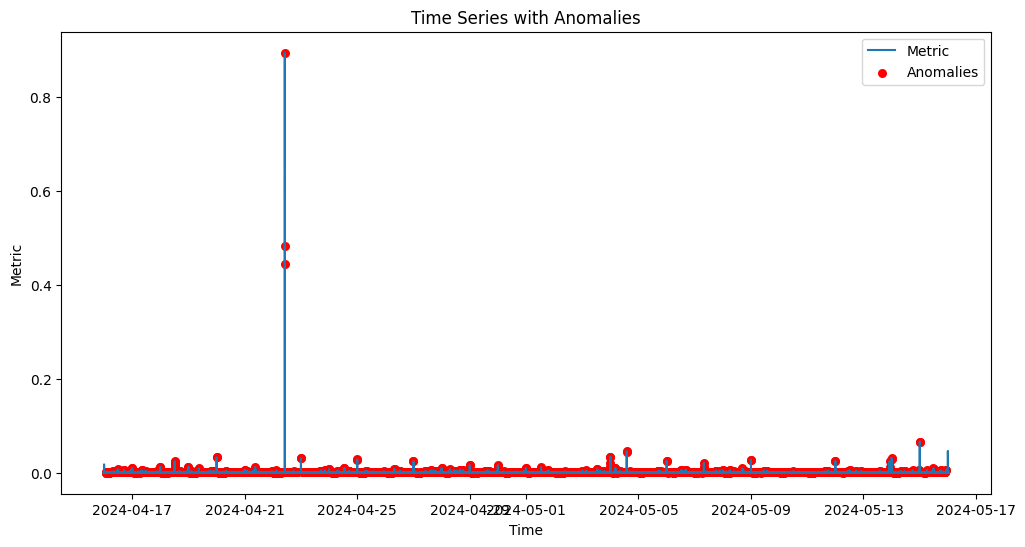

In [134]:
plt.figure(figsize=(12, 6))
plt.plot(error(data)['time'], error(data)['metric'], label='Metric')
plt.scatter(error(data)['time'][kde_mask == 1], error(data)['metric'][kde_mask == 1], color='red', label='Anomalies', s=30)
plt.xlabel('Time')
plt.ylabel('Metric')
plt.title('Time Series with Anomalies')
plt.legend()
plt.show()

In [127]:
throughput(data)['metric'][kde_mask == 1]

202      1815.0
240      1701.5
269      1645.5
1706     1899.0
1729     1714.0
          ...  
40721    1968.5
41886    2065.5
42024    1489.5
42039    1569.5
42093    1797.5
Name: metric, Length: 137, dtype: float64